# Problem Statement

Google Street View offers a plethora of images documenting how America looks on the ground. The question we are trying to answer in our project is the following: _Are we able to systematically identify differences in these images that can be used to classify a district as blue or red?_

Our Team Presentation video can be found here: https://youtu.be/EgICofioLaE

# Table of Contents

* Hypothesis
* Exploring and Visualizing Data
* Creating the Training and Testing Datasets
* Baseline Model
* Generalized Model
* Transfer Learning: VGG16
* Transfer Learning: Landscape
* Discussion and Conclusion

Note: Two additional notebooks are included in our submission. One includes code for web scrapping and image processing, while the other details the training of our landscape detection model. 

## Hypothesis
We expect a few characteristics of images that would be useful in classifying images as from districts that are Democrat or Republican. 
* Based on the literature [(source)](https://www.nytimes.com/interactive/2021/04/06/upshot/trump-biden-quiz-photos.html), it seemed that the landscape has quite a lot to do with this. We suspected that areas with more buildings would be more likely Democrat and areas with more land and greenery would be more likely Republican. We additionally suspected that images with more street would be more likely to be Republican (because of highways). 
* Another feature that we considered was the amount of sky in a photo. If there is less sky in a photo, then we can assume that more of the photo is taken up by buildings or trees. If we are able to differentiate between buildings and trees, then we suspect that we would be able to use the sky feature to differentiate between dense urban environments and rural areas.

We considered other features that we may be able to extract (i.e. truck vs. other cars, which we initially expected to be a contributing factor), but many of these were actually not correlated with a Democratic or Republican district, according to the literature [(source)](https://www.nytimes.com/interactive/2021/04/06/upshot/trump-biden-quiz-photos.html).  

# Exploring Data 
### Data Summary
Our outcome variable is pulled from the outcome of the 2022 election. Our outcome variable is the binary variable of the outcome of the 2022 election. This variable was calculated by taking the 2022 midterm election results from Bloomberg Election Results and the winner of the election, or the incumbent, determined the party that won the voting district. This voting district is labeled as the [state ID] - [district ID].  

Our X data was randomly sampled from Google Street View across the US. We are able to use web scraping from the following site [(source)](https://randomstreetview.com/us) to gather images and associated zip codes. We then appropriately crop and resize the images and match zip codes to congressional districts via the following site [(source)](https://www.geocod.io/) to create our final dataset.

In order to balance out the dataset, we added some of our data from the University of Central Florida [(source)](https://www.crcv.ucf.edu/data/GMCP_Geolocalization/), which is sampled from Democratic Cities: Manhattan, Pittsburgh, and Orlando. 

We used approximately 14k data points on labelled different kinds of landscapes (buildings, mountains, glaciers, streets, forest, and sea) and used transfer learning to retrain the last few layers of the existing model. We obtained the data from [Kaggle](https://www.kaggle.com/datasets/puneet6060/intel-image-classification). 

### Data Description
We ended up with approximately 50.4% of the images from red congressional districts and 49.6% of the images from blue congressional districts (based on election results in 2022). 

Since republican districts geographically take up more of the US so if we simply randomly sample latitude and longitudes across a space, we will naturally end up in more congressional districts that voted republican in 2022. This is why we merged in images separately from the University of Florida which were largely from democratic districts. These images were from Orlando, Pittsburgh, Manhattan.

Below shows a map of the randomly sampled images from Google Street View. 

![my image](sampled_map.png)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import os
import re
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPool2D, AveragePooling2D, Flatten, Dense, Dropout, concatenate
#from tensorflow.keras.models import Sequential, Model
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.pyplot as plt
import random
from tensorflow.keras.utils import plot_model

In [ ]:
daniela_path = 'drive/MyDrive/Class/CS209b/CS209b_Final_Project'
elie_path = "drive/MyDrive/CS209b_Final_Project"
luke_path = 'drive/MyDrive/CS209b_Final_Project'
gpu_path = ''
path = ''

# Creating the Training and Testing Datasets

Here, we first fetch the dataframe that has the image ID and the election result from the 2022 elections into a dataframe called `df_outcome`. The first 10,000 images come from our random location web scrapping, while the additional 4,000 urban images come from the preexisting UCF dataset.

We then create a dataframe with images in the `image` column.

Once these are fetched into on unified dataframe, we creat our `x_train, x_test, y_train, y_test` with 20%-80% split for testing, and then we create a data generator for our tensor flow model pipeline.

In [ ]:
# Define the directory containing the image files
images_directory = path + '/location_data/croppedimages/'
outcome_directory = path + '/outcome_data/'

# Fetch the dataframe that has the image ID and the election result
df_outcome = pd.read_csv("final_outcome.csv", index_col="ID")
df_outcome.head()

,DEM,Latitude,Longitude
ID,,,
338.0,0,31.129427,-87.096126
347.0,0,31.090730,-88.228060
960.0,0,30.666959,-88.226989
1268.0,0,30.509877,-88.173001
1767.0,0,30.509877,-88.173001


In [ ]:
#read entire image dataset
data = []

for i in range (14000):
    filename = f'location{i}.jpg'
    folder_path = 'images/croppedimages/'
    imagename = folder_path + filename
    image = Image.open(imagename)
    image = np.array(image)

    try:
      is_democrat = df_outcome.loc[i]['DEM']
      if isinstance(is_democrat, np.float64):
        data.append({'filename': filename, 'image': image, 'ID': i, 'DEM': is_democrat})
    except:
      continue

In [ ]:
#read subset of 5000 images
data = []
random_sample = random.sample(range(14000), 5000)

for i in random_sample:
    filename = f'location{i}.jpg'
    folder_path = 'images/croppedimages/'
    imagename = folder_path + filename
    image = Image.open(imagename)
    image = np.array(image)

    try:
      is_democrat = df_outcome.loc[i]['DEM']
      if isinstance(is_democrat, np.float64):
        data.append({'filename': filename, 'image': image, 'ID': i, 'DEM': is_democrat})
    except:
      continue

In [ ]:
#Generate image dataframe
df = pd.DataFrame(data)
df.shape

(4821, 4)

In [ ]:
df = df.set_index('ID')
df.head(5)

,filename,image,DEM
ID,,,
2711,location2711.jpg,"[[[61, 75, 62], [47, 61, 48], [44, 58, 45], [4...",1.0
4641,location4641.jpg,"[[[69, 110, 164], [71, 112, 166], [72, 113, 16...",1.0
2171,location2171.jpg,"[[[93, 120, 150], [93, 120, 150], [93, 120, 15...",0.0
4769,location4769.jpg,"[[[98, 119, 150], [97, 118, 149], [95, 116, 14...",0.0
10195,location10195.jpg,"[[[156, 124, 103], [174, 144, 120], [179, 149,...",1.0


In [ ]:
del data

In [ ]:
x = df['image'].to_numpy()
x = np.stack(x, axis=0)
y = df['DEM'].to_numpy()
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=109)

# Reshape the image array to be a 4D tensor
x_train = np.reshape(x_train, (x_train.shape[0], 170, 250, 3))
x_test = np.reshape(x_test, (x_test.shape[0], 170, 250, 3))

# Convert the data type of the image arrays to float32 and normalize the data
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

In [ ]:
del x, y

# Baseline Model

We start out with a simple CNN as our baseline model. We trained on data that was approximately 50% Democrat and 50% Republican districts. Also of note, JupyterHub was unable to handle our full 14,000 image dataset. Therefore, we trained all models on a subset of 5,000 images.

In [ ]:
# Define the model architecture
model = keras.Sequential([
    # Convolutional layer with 32 filters, 3x3 kernel size, and ReLU activation
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(170,250,3)),
    # Max pooling layer with 2x2 pool size
    layers.MaxPooling2D((2,2)),
    # Convolutional layer with 64 filters, 3x3 kernel size, and ReLU activation
    layers.Conv2D(64, (3,3), activation='relu'),
    # Max pooling layer with 2x2 pool size
    layers.MaxPooling2D((2,2)),
    # Convolutional layer with 128 filters, 3x3 kernel size, and ReLU activation
    layers.Conv2D(128, (3,3), activation='relu'),
    # Max pooling layer with 2x2 pool size
    layers.MaxPooling2D((2,2)),
    # Flatten the output of the previous layer
    layers.Flatten(),
    # Fully connected layer with 512 units and ReLU activation
    layers.Dense(32, activation='relu'),
    # Dropout layer with 0.5 dropout rate
    layers.Dropout(0.5),
    # Output layer with 1 unit and sigmoid activation
    layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 168, 248, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 84, 124, 32)      0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 82, 122, 64)       18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 41, 61, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 39, 59, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 19, 29, 128)     

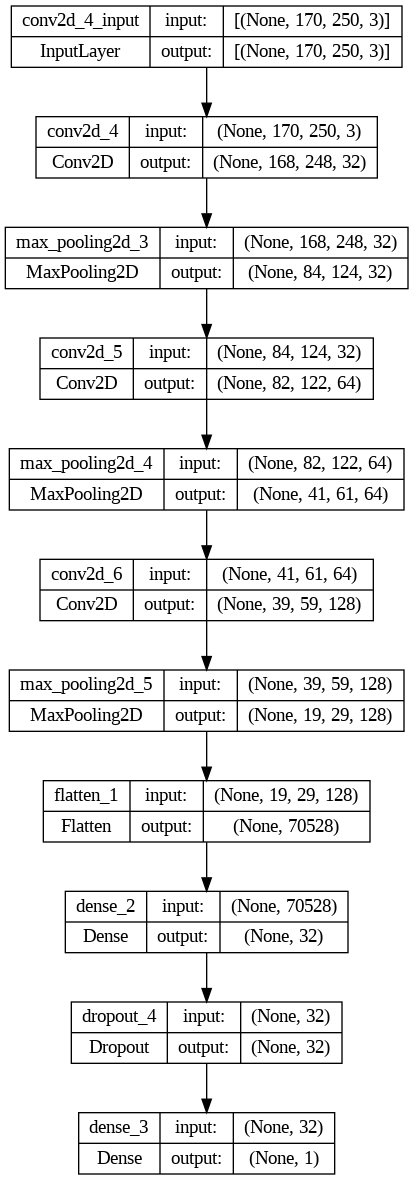

In [ ]:
plot_model(model, show_shapes = True, show_layer_names = True)

In [ ]:
# Train the model on the training data
hist_baseline = model.fit(x_train, y_train, epochs=15, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/15


2023-05-08 18:12:57.565867: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-05-08 18:12:58.272158: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-05-08 18:12:58.774404: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f124c057890 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-05-08 18:12:58.774450: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2023-05-08 18:12:58.779569: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-05-08 18:12:58.869521: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-05-08 18:12:58.939456: I ./tensorflow/compiler/jit/device_compiler.h:180] Com

121/121 [==============================] - 11s 51ms/step - loss: 0.5749 - accuracy: 0.7065 - val_loss: 0.4825 - val_accuracy: 0.7590
Epoch 2/15
121/121 [==============================] - 5s 38ms/step - loss: 0.4684 - accuracy: 0.7834 - val_loss: 0.5084 - val_accuracy: 0.7694
Epoch 3/15
121/121 [==============================] - 5s 38ms/step - loss: 0.4376 - accuracy: 0.8010 - val_loss: 0.4347 - val_accuracy: 0.7808
Epoch 4/15
121/121 [==============================] - 5s 40ms/step - loss: 0.4173 - accuracy: 0.8106 - val_loss: 0.4253 - val_accuracy: 0.7849
Epoch 5/15
121/121 [==============================] - 5s 39ms/step - loss: 0.3946 - accuracy: 0.8170 - val_loss: 0.4441 - val_accuracy: 0.7859
Epoch 6/15
121/121 [==============================] - 5s 39ms/step - loss: 0.3752 - accuracy: 0.8225 - val_loss: 0.4249 - val_accuracy: 0.7859
Epoch 7/15
121/121 [==============================] - 5s 39ms/step - loss: 0.3448 - accuracy: 0.8346 - val_loss: 0.4531 - val_accuracy: 0.7890
Epoch 8/1

In [ ]:
# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(x_test, y_test)
print('Test accuracy:', test_acc)

31/31 [==============================] - 0s 13ms/step - loss: 0.6282 - accuracy: 0.7828
Test accuracy: 0.7828335165977478


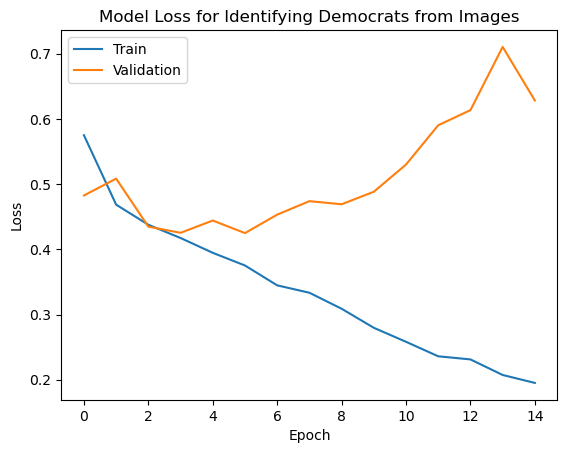

In [ ]:
plt.plot(hist_baseline.history['loss'])
plt.plot(hist_baseline.history['val_loss'])
plt.title('Model Loss for Identifying Democrats from Images')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

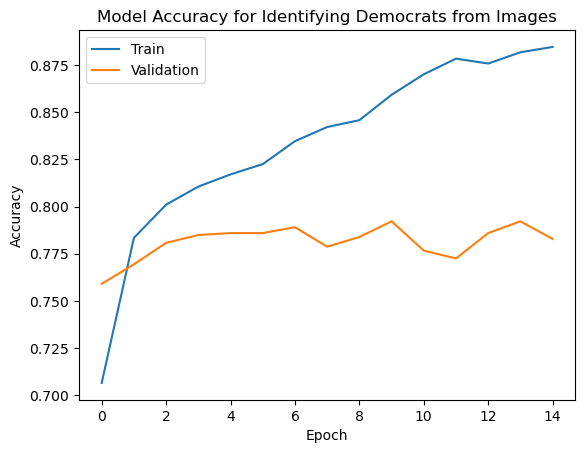

In [ ]:
plt.plot(hist_baseline.history['accuracy'])
plt.plot(hist_baseline.history['val_accuracy'])
plt.title('Model Accuracy for Identifying Democrats from Images')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
np.mean(y_train)

0.4917184265010352

### Interpretation

Our model here is able to accurately predict political affiliation with strong accruacy, especially on the train set, where it achieves 88% accuracy. However, the model does overfit rather quickly, as validation loss steadily increases after the fifth epoch. 

While this is a good start, we needed to make sure our model was more stable and better generalized to new data.

# Generalized Model

In [ ]:
tf.keras.backend.clear_session()
    
# Define the model architecture to better generalize
model_generalize = keras.Sequential([
    # Convolutional layer with 32 filters, 3x3 kernel size, and ReLU activation
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(170,250,3)),
    layers.Conv2D(64, (3,3), activation='relu'),
    # Max pooling layer with 2x2 pool size
    layers.MaxPooling2D((2,2)),
    # Dropout layer
    layers.Dropout(0.3),
    # Convolutional layer with 64 filters, 3x3 kernel size, and ReLU activation
    layers.Conv2D(64, (3,3), activation='relu'),
    # Max pooling layer with 2x2 pool size
    layers.MaxPooling2D((2,2)),
    # Dropout layer
    layers.Dropout(0.3),
    # Convolutional layer with 128 filters, 3x3 kernel size, and ReLU activation
    layers.Conv2D(128, (3,3), activation='relu'),
    # Max pooling layer with 2x2 pool size
    layers.MaxPooling2D((2,2)),
    # Dropout layer
    layers.Dropout(0.3),
    # Flatten the output of the previous layer
    layers.Flatten(),
    # Fully connected layer with 64 units and ReLU activation
    layers.Dense(64, activation='relu'),
    # Dropout layer
    layers.Dropout(0.6),
    # Output layer with 1 unit and sigmoid activation
    layers.Dense(1, activation='sigmoid')
])

# Compile the model
model_generalize.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model_generalize.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 168, 248, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 166, 246, 64)      18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 83, 123, 64)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 83, 123, 64)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 81, 121, 64)       36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 40, 60, 64)       0         
 2D)                                                    

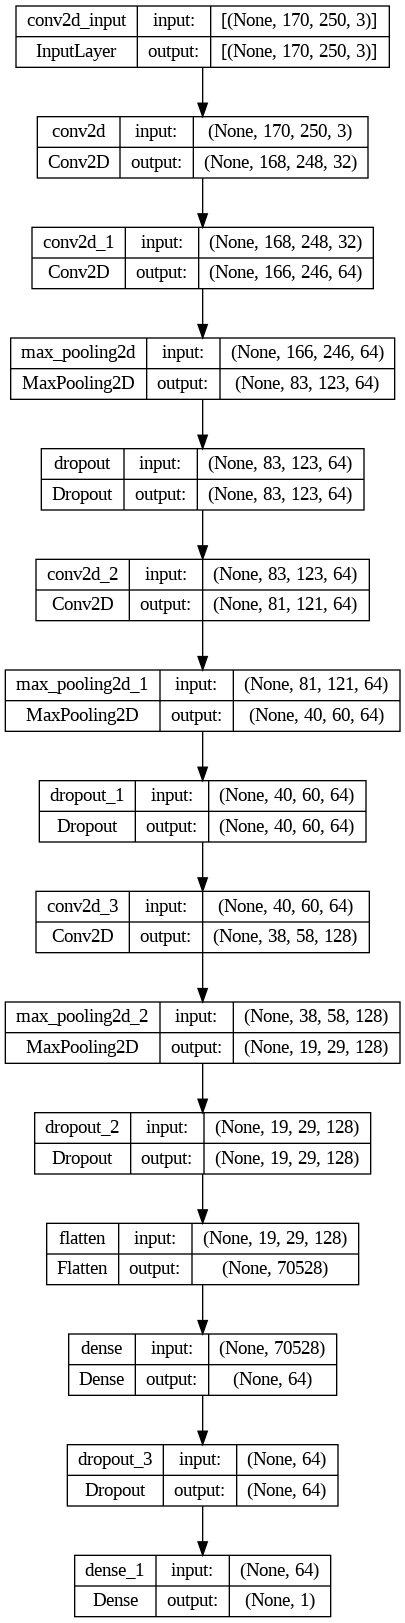

In [ ]:
plot_model(model_generalize, show_shapes = True, show_layer_names = True)

In [ ]:
hist_generalize = model_generalize.fit(x_train, y_train, epochs=15, batch_size=16, validation_data=(x_test, y_test))

Epoch 1/15


2023-05-08 23:42:15.233254: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-05-08 23:42:16.568406: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-05-08 23:42:18.558751: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-05-08 23:42:19.235574: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f8c51f27d40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-05-08 23:42:19.235617: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2023-05-08 23:42:19.240037: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `M

241/241 [==============================] - 29s 84ms/step - loss: 0.6726 - accuracy: 0.5902 - val_loss: 0.5612 - val_accuracy: 0.6839
Epoch 2/15
241/241 [==============================] - 19s 78ms/step - loss: 0.5516 - accuracy: 0.7459 - val_loss: 0.5487 - val_accuracy: 0.7306
Epoch 3/15
241/241 [==============================] - 19s 77ms/step - loss: 0.5109 - accuracy: 0.7586 - val_loss: 0.4680 - val_accuracy: 0.7824
Epoch 4/15
241/241 [==============================] - 19s 77ms/step - loss: 0.4835 - accuracy: 0.7720 - val_loss: 0.4572 - val_accuracy: 0.7855
Epoch 5/15
241/241 [==============================] - 19s 77ms/step - loss: 0.4580 - accuracy: 0.7912 - val_loss: 0.4289 - val_accuracy: 0.7907
Epoch 6/15
241/241 [==============================] - 19s 78ms/step - loss: 0.4389 - accuracy: 0.7956 - val_loss: 0.4161 - val_accuracy: 0.8000
Epoch 7/15
241/241 [==============================] - 19s 78ms/step - loss: 0.4315 - accuracy: 0.7943 - val_loss: 0.4172 - val_accuracy: 0.7896
Epo

In [ ]:
# Evaluate the model on the test data
test_loss, test_acc = model_generalize.evaluate(x_test, y_test)
print('Test accuracy:', test_acc)

31/31 [==============================] - 2s 25ms/step - loss: 0.4297 - accuracy: 0.8041
Test accuracy: 0.804145097732544


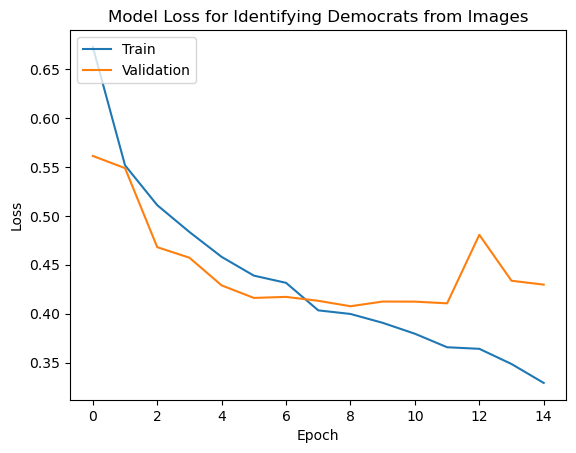

In [ ]:
plt.plot(hist_generalize.history['loss'])
plt.plot(hist_generalize.history['val_loss'])
plt.title('Model Loss for Identifying Democrats from Images')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

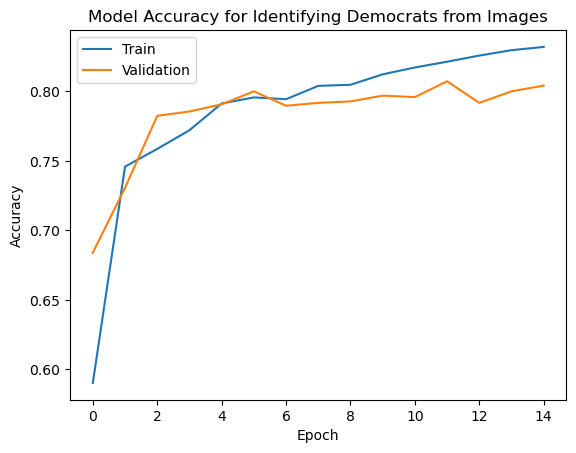

In [ ]:
plt.plot(hist_generalize.history['accuracy'])
plt.plot(hist_generalize.history['val_accuracy'])
plt.title('Model Accuracy for Identifying Democrats from Images')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Interpretation

Once again our model achieves strong accuracy, this time with notably better generalization. While training accuracy dips slightly to 84%, test accuracy peaks at 81%. Compared to both a baseline of guess Democrat each time (50.4%) and human performance in the NYT exercise (60-67% on average), the accuracy the model is able to achieve is impressive.

We now attempt to improve accuracy through transfer learning.

### Saliency Maps

In [ ]:
#define function for plotting saliency maps
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils import normalize
from matplotlib import cm

def plot_smooth_CAM(model, input_image, label, title, output_activation='softmax'):

    #Define function to change output activation to linear
    def softmax_to_linear(m):
        if not output_activation != 'softmax':
            m.layers[-1].activation = tf.keras.activations.linear

    #Create saliency object
    saliency = Saliency(model, softmax_to_linear)

    #Define loss function
    if output_activation=='softmax':
        loss = lambda output: tf.keras.backend.mean(
            output[:, int(label)]
        ) 
    else:
        loss = lambda output: tf.keras.backend.mean((output - label)**2)

    #Generate saliency map with smoothing
    saliency_map = saliency(loss, input_image, smooth_samples=20)
    saliency_map = normalize(saliency_map)

    #Create Gradcam object
    gradcam = Gradcam(model, softmax_to_linear)

    #Generate heatmap
    cam = gradcam(loss, input_image, penultimate_layer=-1)
    cam = normalize(cam)
    heatmap = np.uint8(cm.viridis(cam[0])[..., :3] * 255)
    
    #Plot
    fig, ax = plt.subplots(1, 3, figsize=(7, 3.75), subplot_kw={'xticks': [], 'yticks': []})
    plt.suptitle(title, fontsize=18, y=1)
    ax[0].imshow(input_image)
    ax[1].imshow(saliency_map[0], cmap='viridis')
    ax[2].imshow(input_image.sum(axis=2), cmap='gray')
    ax[2].imshow(heatmap, cmap='viridis', alpha=0.5)
    
    for i, title in enumerate(
        ['Original image', 'SmoothGrad\nSaliency map', 'Grad-CAM Salinecy\nheatmap']):
        ax[i].set_title(title, fontsize=14)
    
    plt.tight_layout()
    plt.show();

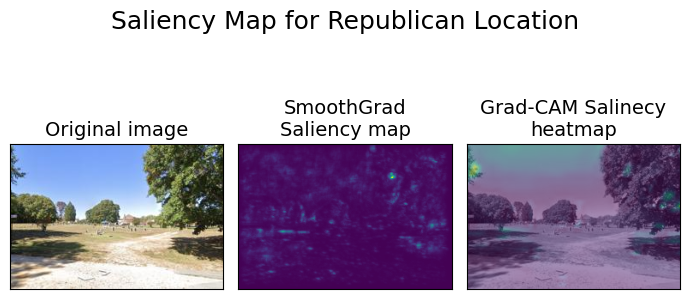

In [ ]:
plot_smooth_CAM(model_generalize, x_train[10], 0, 'Saliency Map for Republican Location', output_activation='sigmoid')

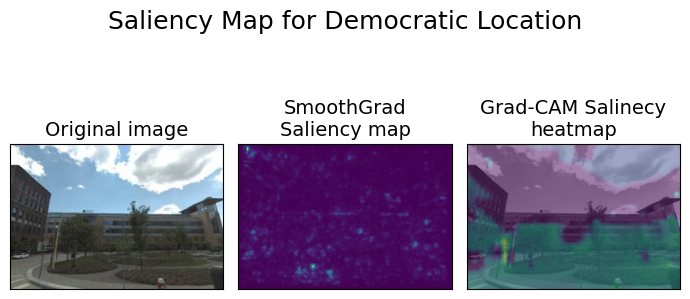

In [ ]:
plot_smooth_CAM(model_generalize, x_train[12], 1, 'Saliency Map for Democratic Location', output_activation='sigmoid')

### Interpretation 

It seems that the model focuses on sky and greenery more in images from Republican districts. The model focuses more on buidlings and straight lines while ignoring the sky in Democratic districts. 

# Transfer Learning: VGG16 (Imagenet)
In attempt to increase model accuracy, we use transfer learning via a VGG16 architecture pretrained on imagenet. It is possible that the pretrained weights could identify objects in images (cars, buildings, trees, bushes, etc.) that could aid in prediction of political affiliation.

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam

tf.keras.backend.clear_session()

# Load the pre-trained VGG16 model without the top classification layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(170, 250, 3))

# Create a new model and add the pre-trained VGG16 base
model_vgg = Sequential()
model_vgg.add(base_model)

# Flatten the feature maps
model_vgg.add(Flatten())

# Add dense and dropout layers
model_vgg.add(Dense(1, activation='softmax'))

# Compile the model
model_vgg.compile(optimizer=Adam(.01), loss='binary_crossentropy', metrics=['accuracy'])

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
model_vgg.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 5, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 17920)             0         
                                                                 
 dense (Dense)               (None, 1)                 17921     
                                                                 
Total params: 14,732,609
Trainable params: 14,732,609
Non-trainable params: 0
_________________________________________________________________


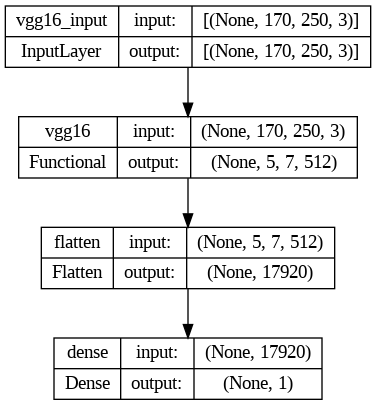

In [ ]:
plot_model(model_vgg, show_shapes = True, show_layer_names = True)

In [ ]:
# Train the model
hist_vgg = model_vgg.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/10
121/121 [==============================] - 68s 437ms/step - loss: 37775956.0000 - accuracy: 0.5041 - val_loss: 1.4508 - val_accuracy: 0.4979
Epoch 2/10
121/121 [==============================] - 43s 359ms/step - loss: 1.0480 - accuracy: 0.5041 - val_loss: 1.0518 - val_accuracy: 0.4979
Epoch 3/10
121/121 [==============================] - 43s 358ms/step - loss: 0.7766 - accuracy: 0.5041 - val_loss: 1.5220 - val_accuracy: 0.4979
Epoch 4/10
121/121 [==============================] - 43s 357ms/step - loss: 0.9416 - accuracy: 0.5041 - val_loss: 0.7322 - val_accuracy: 0.4979
Epoch 5/10
121/121 [==============================] - 42s 350ms/step - loss: 0.7686 - accuracy: 0.5041 - val_loss: 0.7634 - val_accuracy: 0.4979
Epoch 6/10
121/121 [==============================] - 42s 343ms/step - loss: 0.7434 - accuracy: 0.5041 - val_loss: 0.7257 - val_accuracy: 0.4979
Epoch 7/10
121/121 [==============================] - 41s 342ms/step - loss: 0.8622 - accuracy: 0.5041 - val_loss: 0.7282 -

In [ ]:
# Evaluate the model on the test data
test_loss, test_acc = model_vgg.evaluate(x_test, y_test)
print('Test accuracy:', test_acc)

31/31 [==============================] - 3s 96ms/step - loss: 0.6996 - accuracy: 0.4979
Test accuracy: 0.49793389439582825


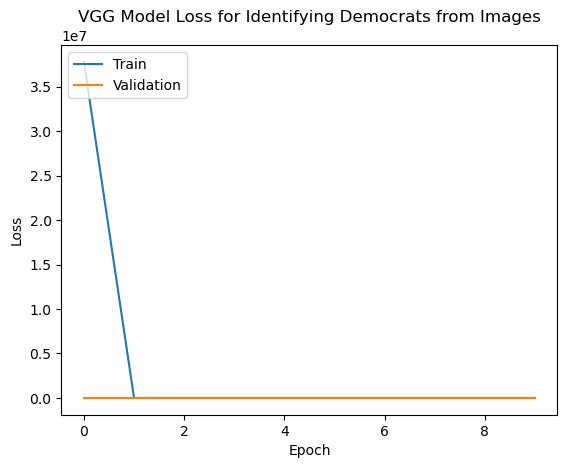

In [ ]:
plt.plot(hist_vgg.history['loss'])
plt.plot(hist_vgg.history['val_loss'])
plt.title('VGG Model Loss for Identifying Democrats from Images')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

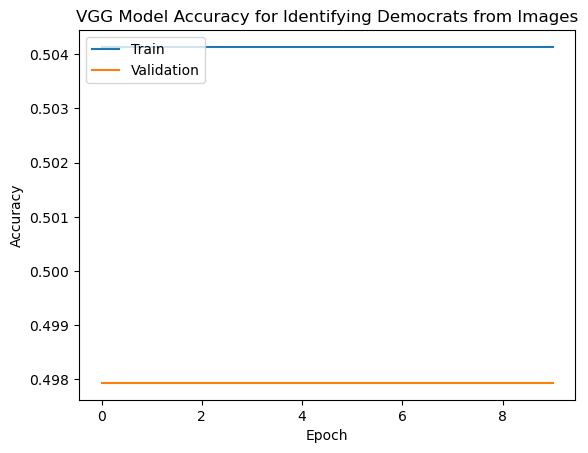

In [ ]:
plt.plot(hist_vgg.history['accuracy'])
plt.plot(hist_vgg.history['val_accuracy'])
plt.title('VGG Model Accuracy for Identifying Democrats from Images')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Interpretation

Our imagenet based network performed very poorly; it was not able to achieve above baseline accuracy, guessing Democrat every time. We attempted training with both frozen pretrained weights and trainable weights and got the same result in each trial.

Ultimately, imagenet may be trained on too many different kinds of images to be useful for our purposes.

# Transfer Learning: Landscape Classifier

This landscape model started on VGG19. An explanation of how we made this model is in the landscape_tensor.ipynb. We saved this model's weights and architecture as 'my_model.h5'. We are now loading in that model and predicting on our images. 

We first apply the model to our dataset to generate landscape predictions. Based on our predicted results on the 5000 images, it seems that there are no statistical differences in landscape detection for Democratic vs. Republican districts.

We then create a transfer learning model that uses the landscape detection parameters as the convolutional layers of the network.

In [ ]:
landscape_model = tf.keras.models.load_model('my_model.h5')

In [ ]:
desired_shape = (150, 150)

def pred_landscape(x): 
    # Resize the image
    resized_image = tf.image.resize(x, size=desired_shape)
    resized_image = tf.expand_dims(resized_image, axis=0)
    return np.argmax(landscape_model.predict(resized_image))

In [ ]:
classes = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

In [ ]:
df['landscape'] = df['image'].apply(pred_landscape)

Text(0.5, 1.0, 'Classification: 1 (Forest)')

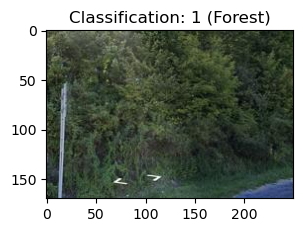

In [ ]:
import cv2
img = cv2.imread('images/croppedimages/location7929.jpg')[:,:,::-1]
plt.figure(2)
plt.subplot(2,1,1)
plt.imshow(img)
plt.title('Classification: ' + str(df.loc[7929]['landscape']) + ' (Forest)')

Text(0.5, 1.0, 'Classification: 5 (Building)')

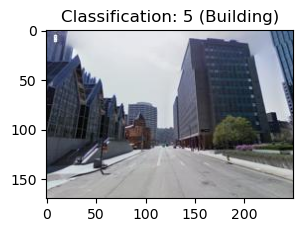

In [ ]:
import cv2
img = cv2.imread('images/croppedimages/location10556.jpg')[:,:,::-1]
plt.figure(2)
plt.subplot(2,1,1)
plt.imshow(img)
plt.title('Classification: ' + str(df.loc[10556]['landscape']) + ' (Building)')

In [ ]:
counts_1 = df.loc[df.DEM == 1].index
counts_0 = df.loc[df.DEM == 0].index

In [ ]:
df['landscape'][counts_1].value_counts().reset_index()['count']

0    1625
1     608
2      95
3      28
4      18
5       9
Name: count, dtype: int64

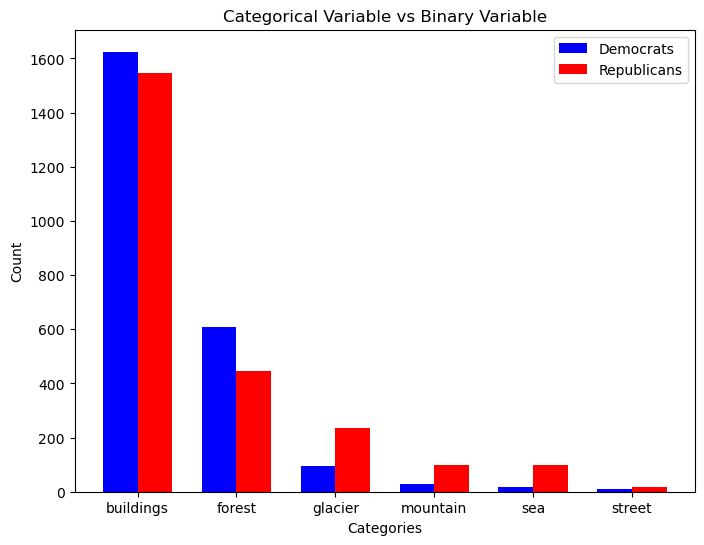

In [ ]:
plt.figure(figsize=(8, 6))

bar_positions = np.arange(len(df.landscape.unique()))
bar_width = .35

plt.bar(bar_positions, 
        df['landscape'][counts_1].value_counts().reset_index()['count'], 
        color='blue',
        label='Democrats', 
        width=bar_width)
plt.bar(bar_positions + bar_width, 
        df['landscape'][counts_0].value_counts().reset_index()['count'], 
        color='red',
        label='Republicans', 
        width=bar_width)
plt.xticks(bar_positions + bar_width / 2, ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street'])
plt.xlabel('Categories')
plt.ylabel('Count')
plt.title('Categorical Variable vs Binary Variable')
plt.legend()
plt.show()

In [ ]:
#Create dataframe with resized images for landscape model
resize_df = df

def resize_image(img):
    img = Image.fromarray(img)
    crop = img.crop((50,10,200,160))
    return crop

In [ ]:
# Apply the resize_image function
resize_df['image'] = resize_df['image'].apply(resize_image)

In [ ]:
#Redefine train/test sets
x = resize_df['image'].to_numpy()
x = np.stack(x, axis=0)
y = resize_df['DEM'].to_numpy()
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=109)

# Reshape the image array to be a 4D tensor
x_train = np.reshape(x_train, (x_train.shape[0], 150, 150, 3))
x_test = np.reshape(x_test, (x_test.shape[0], 150, 150, 3))

# Convert the data type of the image arrays to float32 and normalize the data
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

In [ ]:
tf.keras.backend.clear_session()

# Create a new model and add the pre-trained VGG16 base
land_model_binary = Sequential()
land_model_binary.add(landscape_model)

# Flatten the feature maps
land_model_binary.add(Flatten())

# Add dense layer for binary classification
land_model_binary.add(Dense(1, activation='softmax'))

# Compile model
land_model_binary.compile(optimizer=Adam(.01), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
land_model_binary.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_3 (Functional)        (None, 6)                 20073542  
                                                                 
 flatten (Flatten)           (None, 6)                 0         
                                                                 
 dense (Dense)               (None, 1)                 7         
                                                                 
Total params: 20,073,549
Trainable params: 49,165
Non-trainable params: 20,024,384
_________________________________________________________________


In [ ]:
hist_land = land_model_binary.fit(x_train, y_train, epochs=15, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/15
121/121 [==============================] - 13s 101ms/step - loss: 0.6159 - accuracy: 0.4931 - val_loss: 0.5785 - val_accuracy: 0.4974
Epoch 2/15
121/121 [==============================] - 12s 98ms/step - loss: 0.5615 - accuracy: 0.4931 - val_loss: 0.5152 - val_accuracy: 0.4974
Epoch 3/15
121/121 [==============================] - 12s 99ms/step - loss: 0.5360 - accuracy: 0.4931 - val_loss: 0.4923 - val_accuracy: 0.4974
Epoch 4/15
121/121 [==============================] - 12s 99ms/step - loss: 0.5042 - accuracy: 0.4931 - val_loss: 0.4900 - val_accuracy: 0.4974
Epoch 5/15
121/121 [==============================] - 12s 101ms/step - loss: 0.4976 - accuracy: 0.4931 - val_loss: 0.6620 - val_accuracy: 0.4974
Epoch 6/15
121/121 [==============================] - 12s 101ms/step - loss: 0.5130 - accuracy: 0.4931 - val_loss: 0.4846 - val_accuracy: 0.4974
Epoch 7/15
121/121 [==============================] - 12s 101ms/step - loss: 0.5164 - accuracy: 0.4931 - val_loss: 0.4889 - val_accur

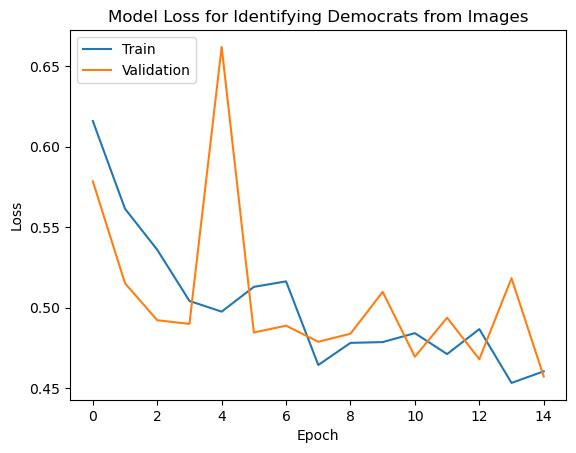

In [ ]:
plt.plot(hist_land.history['loss'])
plt.plot(hist_land.history['val_loss'])
plt.title('Model Loss for Identifying Democrats from Images')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

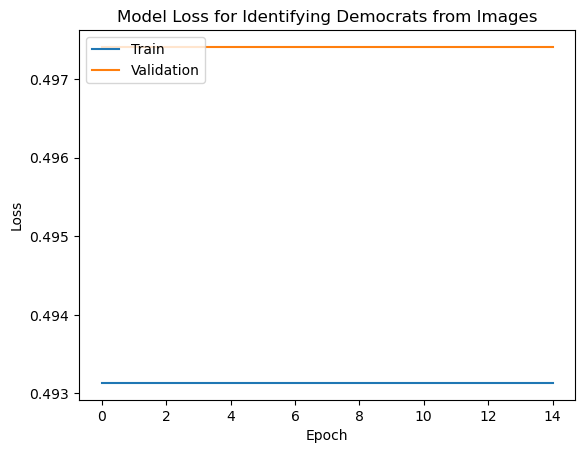

In [ ]:
plt.plot(hist_land.history['accuracy'])
plt.plot(hist_land.history['val_accuracy'])
plt.title('Model Loss for Identifying Democrats from Images')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Interpretation

Similarly to the imagenet based model, transfer learning here does not produce good results. Again, we fail to achieve above baseline accuracy. Essentially, this model amounted to a logistic regression, where party affiliation is predicted by the coefficients of our six landscape classifications. Therefore, our poor accuracy shouldn't be entirely surprising.

# Discussion & Conclusion

After not including specialized features, we opted to stick to our improved model. 
Our baseline succesfully beat a naive prediction algorithm that would simply predict one label at all times and thus get a 50% accuracy. Our baseline accuracy was 88% for the training and 79% for the testing accuracy. By adding more dropout layers, deepening the network, and decreasing the batch size, the model was able generalize and achieve an 81% accuracy on test. This was the model we used in our final prediction, which was against our hypothesis because we assumed that the features we extracted would have more predictive power. 

There are a set of models that we opted not to use. We used transfer learning on ImageNet's VGG16 architecture which was trained to identify objects. Both freezing all layers and not freezing layers led to a low accuracy of around 50%, which is not improved from a naive model.

Additionally, we deployed two models for feature extractions. The first model was a sky detector from an existing mask in the CV package in python. This sky detection resulted in poor accuracy for predicting the party affiliation combined with the baseline model. Hence, we opted to extract a more complex model to detect different landscapes based on our hypotheses above. This landscape detection model was a transfer learning model from ImageNet's VGG19 model and retrained on the last layer to predict one of 6 landscape types. After training on 14k labelled landscape images, we predicted on our Google Street View data and found that there was no statistically significant difference between the landscapes and across Republican and Democratic Districts. These were against our original hypotheses, however, it didn't improve the accuracies, and thus, we did not include these features in our final model. 

One limitation is that our model was trained on randomly sampled data from across the US, so there are some images that have little information about party affiliation (such as empty fields or a close up of trees). It may be useful to systematically concentrate our image sampling method to populated areas. 

Future work is required to identify more prominant features that could be more useful in predicting party affiliation (i.e. American Flags or Trucks would be more likely found in a Republican District). Additionally, training the model on more data could be useful in increasing the accuracy, and data augmentation could further increase generalizabilty.